In [1]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import settings

In [2]:
dietary_data_path = f'{settings.output_folder}diet.csv'
development_data_path = f'{settings.raw_data_folder}control/country_development_data.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'

In [3]:
food_data = pd.read_csv(dietary_data_path)
food_data = food_data[food_data.columns[2:]].drop(['Confirmed', 'Deaths', 'Recovered'],axis=1)
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables,Country
0,0.000030,0.326636,0.223147,0.0,0.733914,0.132792,0.000638,0.148116,0.133538,0.025586,...,0.090683,0.008648,0.101278,0.0,0.093136,0.113588,0.663569,0.246708,0.320304,Afghanistan
1,0.095202,0.741183,0.154200,0.0,0.146948,0.460113,0.022935,0.274058,0.283455,0.039222,...,0.000402,0.036580,0.119830,0.0,0.145522,0.221400,0.226743,0.149209,0.592018,Albania
2,0.011670,0.274016,0.034457,0.0,0.378697,0.313765,0.024193,0.237088,0.103129,0.076753,...,0.080131,0.086139,0.109900,0.0,0.176586,0.160859,0.745976,0.556105,0.585138,Algeria
3,0.251279,0.199301,0.053595,0.0,0.288345,0.022781,0.184776,0.189200,0.290182,0.051748,...,0.001731,0.534029,0.030582,0.0,0.130798,0.004750,0.764589,0.390946,0.078466,Angola
4,0.226478,0.656624,0.171604,0.0,0.131001,0.118321,0.346861,0.356505,0.621373,0.217600,...,0.216778,0.023982,0.225526,0.0,0.318216,0.043980,0.311472,0.346539,0.249017,Antigua and Barbuda


In [4]:
development_data = pd.read_csv(development_data_path)
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,...,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,...,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,...,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,...,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,...,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,...,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [5]:
reg = pd.read_csv(targets_path)
targets = reg[['Country', 'Deaths', 'Confirmed', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       0
Confirmed    0
Recovered    0
dtype: int64


,Country,Deaths,Confirmed,Recovered
0,Afghanistan,0.006186,0.142134,0.123374
1,Albania,0.050951,2.967301,1.792636
2,Algeria,0.006558,0.244897,0.167572
3,Angola,0.001461,0.061687,0.056808
4,Argentina,0.108227,4.356147,3.905192


In [6]:
merged = food_data.merge(development_data, how='inner', on='Country')
merged = merged.merge(targets, on='Country', how='inner')
merged.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature,Deaths,Confirmed,Recovered
0,0.000030,0.326636,0.223147,0.0,0.733914,0.132792,0.000638,0.148116,0.133538,0.025586,...,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820,0.006186,0.142134,0.123374
1,0.095202,0.741183,0.154200,0.0,0.146948,0.460113,0.022935,0.274058,0.283455,0.039222,...,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493,0.050951,2.967301,1.792636
2,0.011670,0.274016,0.034457,0.0,0.378697,0.313765,0.024193,0.237088,0.103129,0.076753,...,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447,0.006558,0.244897,0.167572
3,0.251279,0.199301,0.053595,0.0,0.288345,0.022781,0.184776,0.189200,0.290182,0.051748,...,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425,0.001461,0.061687,0.056808
4,0.185313,0.713814,0.173578,0.0,0.161196,0.548327,0.037607,0.152709,0.821974,0.000000,...,0.030064,0.240648,0.022857,0.839132,0.496665,0.362201,0.791878,0.108227,4.356147,3.905192


In [7]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_all =  merged.columns.drop(['Country'])
features_all = features_all.drop(label_values)
features_all = features_all.drop(['WHO code', 'FAO code'])

In [8]:
X_all = merged[features_all]
Y_all = merged[label_values]

In [9]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [60]:
def rfecv_shap_algorithm(estimator, X, Y, algorithm, step=1, score='neg_median_absolute_error'):
  shap_elimination = ShapRFECV(clf=estimator, step=step, cv=6, scoring=score, n_jobs=-1)
  shap_report = shap_elimination.fit_compute(X, Y)
  best_features_rfe_shap = shap_report[shap_report['val_metric_mean'] == shap_report['val_metric_mean'].max()]
  features_shap = list(best_features_rfe_shap['features_set'].values[0])
  features_shap_cv = {}
  features_shap_cv['algorithm'] = 'rfe - measure shap ' + algorithm
  features_shap_cv['selected_features'] = features_shap
  features_shap_cv['number_of_features'] = len(features_shap)
  features_shap_cv['neg_mae_score_cv'] = shap_report['val_metric_mean'].max()
  feat_shap = pd.DataFrame(features_shap_cv)
  feat_shap.to_csv(f'{settings.features_folder}selected_features_rfe_shap_' + algorithm + '.csv', index=False)
  return feat_shap

In [11]:
PARAMS = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200],
    'colsample_bytree': [1, 0.9, 0.8, 0.7]
}

In [12]:
xgb_all_params, xgb_all_score = hyper_parameter_search(X_all, Y_all['Deaths'], PARAMS)

In [13]:
print(f'best parameters: {xgb_all_params}')
print(f'score: {xgb_all_score}')

best parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50}
score: -0.02382482542857526


In [14]:
xgb_all = XGBRegressor(gamma = xgb_all_params['gamma'],
                               learning_rate = xgb_all_params['learning_rate'], 
                               max_depth = xgb_all_params['max_depth'],
                               min_child_weight = xgb_all_params['min_child_weight'], 
                               n_estimators = xgb_all_params['n_estimators'],
                               colsample_bytree = xgb_all_params['colsample_bytree'],
                               random_state=0)

In [61]:
rfecv_xgb_all = rfecv_shap_algorithm(xgb_all, X_all, Y_all['Deaths'], 'food_control')

In [62]:
rfecv_xgb_all

,algorithm,selected_features,number_of_features,neg_mae_score_cv
0,rfe - measure shap food_control,Winter Average Temperature,5,-0.011
1,rfe - measure shap food_control,hdi_2016,5,-0.011
2,rfe - measure shap food_control,Eggs,5,-0.011
3,rfe - measure shap food_control,Min Longitude,5,-0.011
4,rfe - measure shap food_control,Max Latitude,5,-0.011


In [63]:
selected_features_all = rfecv_xgb_all['selected_features'].values

In [64]:
X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(
    X_all[selected_features_all],
    Y_all,
    test_size = 0.2,
    random_state=0
)

In [65]:
xgb_all.fit(X_train_all, Y_train_all['Deaths'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

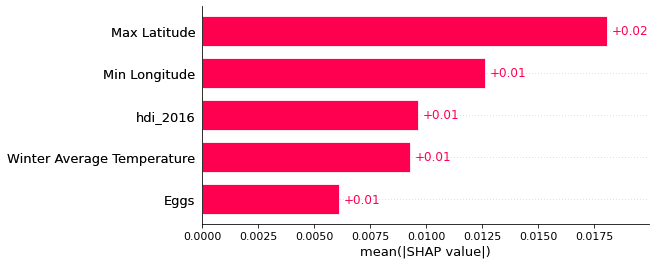

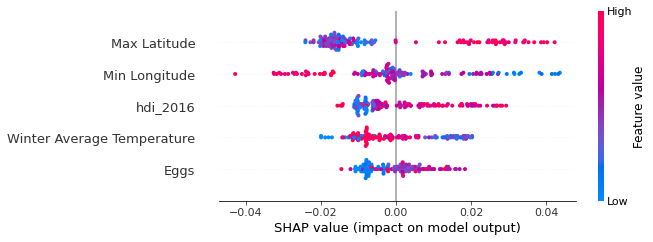

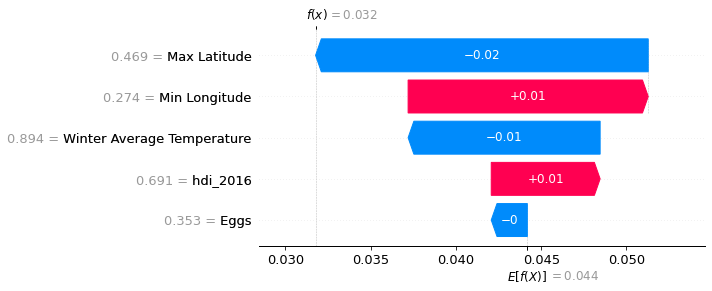

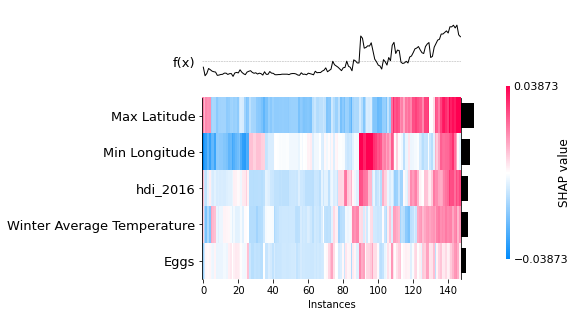

In [66]:
expl = shap.Explainer(xgb_all, X_all[selected_features_all])
shap_values = expl(X_all[selected_features_all])
shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.waterfall(shap_values[30])
shap.plots.heatmap(shap_values)